
### <font color='blue'>IA na Indústria - Prevendo Indicadores de Produção ao Longo do Tempo</font>
#### <font color='blue'>com Série Temporal Multivariada e Modelo Transformer</font>

O objetivo é utilizar Inteligência Artificial para prever a demanda de insumos por turno de fabricação com base em diversos indicadores como rendimento, defeitos, disponibilidade de máquinas e eficiência. 

## Instalando e Carregando os Pacotes

In [3]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [4]:
!pip install -q torch==1.13.1

In [5]:
!pip install -q pytorch_lightning==1.9.5

In [6]:
!pip install -q pytorch-forecasting==0.10.3

In [7]:
!pip install -q tensorflow==2.13.0

In [8]:
!pip install -q statsmodels==0.13.2

Recomendamos o uso de GPU para este projeto (o Google Colab pode ser usado) e caso tenha algum problema de conflito entre os pacotes, desinstale o torchvision via terminal:

pip uninstall torchvision

In [9]:
# Imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from torchmetrics import MeanAbsolutePercentageError
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import tensorflow as tf 
import warnings
warnings.filterwarnings('ignore')

In [10]:
%matplotlib inline
pd.set_option("display.precision", 2)
np.set_printoptions(precision = 2, suppress = True)
pd.options.display.float_format = '{:,.2f}'.format

In [12]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


In [13]:
if torch.cuda.is_available():
    print('Número de GPUs:', torch.cuda.device_count())
    print('Modelo GPU:', torch.cuda.get_device_name(0))
    print('Total Memória [GB] da GPU:',torch.cuda.get_device_properties(0).total_memory / 1e9)

Número de GPUs: 1
Modelo GPU: NVIDIA GeForce RTX 3080 Laptop GPU
Total Memória [GB] da GPU: 8.361017344


In [14]:
# Seed
seed = 777
torch.manual_seed(seed)

## Carregando e Compreendendo os Dados

In [15]:
# Carrega o dataset
dados = pd.read_csv("dados/dataset.csv", index_col = 0)

In [16]:
len(dados)

52416

In [17]:
# Shape
dados.shape

(52416, 8)

In [18]:
# Info
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52416 entries, 1/1/23 0:00 to 12/30/23 23:50
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Indicador_MTTR   52416 non-null  float64
 1   Indicador_EME    52416 non-null  float64
 2   Indicador_ICE    52416 non-null  float64
 3   Indicador_ITMIE  52416 non-null  float64
 4   Indicador_IQMP   52416 non-null  float64
 5   Turno1           52416 non-null  float64
 6   Turno2           52416 non-null  float64
 7   Turno3           52416 non-null  float64
dtypes: float64(8)
memory usage: 3.6+ MB


In [19]:
# Primeiras 5 linhas
dados.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
Data,,,,,,,,
1/1/23 0:00,6.56,73.80,0.08,0.05,0.12,"34,055.70","16,128.88","20,240.96"
1/1/23 0:10,6.41,74.50,0.08,0.07,0.09,"29,814.68","19,375.08","20,131.08"
1/1/23 0:20,6.31,74.50,0.08,0.06,0.10,"29,128.10","19,006.69","19,668.43"
1/1/23 0:30,6.12,75.00,0.08,0.09,0.10,"28,228.86","18,361.09","18,899.28"
1/1/23 0:40,5.92,75.70,0.08,0.05,0.09,"27,335.70","17,872.34","18,442.41"


In [20]:
# Imprime a primeira e a última linha
dados.iloc[[0,-1]]

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
Data,,,,,,,,
1/1/23 0:00,6.56,73.80,0.08,0.05,0.12,"34,055.70","16,128.88","20,240.96"
12/30/23 23:50,6.58,74.10,0.08,0.06,0.11,"28,349.81","24,055.23","13,345.50"


In [21]:
# Converte a data para o tipo datetime e define a data como índice
dados.index = pd.to_datetime(dados.index)

In [22]:
len(dados)

52416

In [23]:
# Primeiras 5 linhas
dados.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
Data,,,,,,,,
2023-01-01 00:00:00,6.56,73.80,0.08,0.05,0.12,"34,055.70","16,128.88","20,240.96"
2023-01-01 00:10:00,6.41,74.50,0.08,0.07,0.09,"29,814.68","19,375.08","20,131.08"
2023-01-01 00:20:00,6.31,74.50,0.08,0.06,0.10,"29,128.10","19,006.69","19,668.43"
2023-01-01 00:30:00,6.12,75.00,0.08,0.09,0.10,"28,228.86","18,361.09","18,899.28"
2023-01-01 00:40:00,5.92,75.70,0.08,0.05,0.09,"27,335.70","17,872.34","18,442.41"


## Limpeza, Organização e Análise Exploratória de Dados

In [24]:
# Observe o intervalo das datas!!!!!
dados.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
Data,,,,,,,,
2023-01-01 00:00:00,6.56,73.80,0.08,0.05,0.12,"34,055.70","16,128.88","20,240.96"
2023-01-01 00:10:00,6.41,74.50,0.08,0.07,0.09,"29,814.68","19,375.08","20,131.08"
2023-01-01 00:20:00,6.31,74.50,0.08,0.06,0.10,"29,128.10","19,006.69","19,668.43"
2023-01-01 00:30:00,6.12,75.00,0.08,0.09,0.10,"28,228.86","18,361.09","18,899.28"
2023-01-01 00:40:00,5.92,75.70,0.08,0.05,0.09,"27,335.70","17,872.34","18,442.41"


In [25]:
dados.head(20)

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
Data,,,,,,,,
2023-01-01 00:00:00,6.56,73.80,0.08,0.05,0.12,"34,055.70","16,128.88","20,240.96"
2023-01-01 00:10:00,6.41,74.50,0.08,0.07,0.09,"29,814.68","19,375.08","20,131.08"
2023-01-01 00:20:00,6.31,74.50,0.08,0.06,0.10,"29,128.10","19,006.69","19,668.43"
2023-01-01 00:30:00,6.12,75.00,0.08,0.09,0.10,"28,228.86","18,361.09","18,899.28"
2023-01-01 00:40:00,5.92,75.70,0.08,0.05,0.09,"27,335.70","17,872.34","18,442.41"
2023-01-01 00:50:00,5.85,76.90,0.08,0.06,0.11,"26,624.81","17,416.41","18,130.12"
2023-01-01 01:00:00,5.64,77.70,0.08,0.05,0.10,"25,998.99","16,993.31","17,945.06"
2023-01-01 01:10:00,5.50,78.20,0.09,0.06,0.09,"25,446.08","16,661.40","17,459.28"
2023-01-01 01:20:00,5.68,78.10,0.08,0.07,0.14,"24,777.72","16,227.36","17,025.54"


In [26]:
# Agregamos os dados por hora
dados_hr = dados.resample('1h').mean()

In [27]:
len(dados_hr)

8736

In [28]:
len(dados)

52416

In [29]:
# Amostra dos dados
dados_hr.head(10)

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
Data,,,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"29,197.97","18,026.75","19,252.05"
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"24,657.22","16,078.42","17,042.89"
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"22,083.04","14,330.70","15,676.14"
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"20,811.14","13,219.45","14,883.86"
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"20,475.95","12,921.58","14,317.11"
2023-01-01 05:00:00,4.74,75.23,0.08,0.07,0.12,"20,807.09","13,069.91","14,395.18"
2023-01-01 06:00:00,4.57,75.75,0.08,0.06,0.13,"21,648.61","13,596.35","14,513.73"
2023-01-01 07:00:00,4.45,73.40,0.08,0.07,0.12,"18,540.76","11,449.85","11,552.77"
2023-01-01 08:00:00,4.66,73.60,0.08,13.76,6.31,"19,605.06","11,738.60","11,190.36"


In [30]:
# Verifica valores ausentes
dados_hr.isnull().values.any()

False

In [31]:
# Resumo estatístico
dados_hr.describe()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
count,"8,736.00","8,736.00","8,736.00","8,736.00","8,736.00","8,736.00","8,736.00","8,736.00"
mean,18.81,68.26,1.96,182.70,75.03,"32,344.97","21,042.51","17,835.41"
std,5.81,15.48,2.34,260.82,119.69,"7,068.92","5,165.18","6,591.01"
min,3.60,12.71,0.05,0.02,0.04,"14,329.11","8,685.95","6,190.64"
25%,14.40,58.32,0.08,0.06,0.12,"26,292.95","17,016.90","13,148.47"
50%,18.76,69.82,0.09,9.95,8.24,"32,342.30","20,787.23","16,427.66"
75%,22.87,81.35,4.92,326.49,105.88,"37,318.00","24,677.61","21,598.45"
max,39.70,94.75,5.93,953.35,861.00,"51,844.26","36,254.70","47,223.77"


> Já fizemos o ajuste da sequência de data da série temporal. Vamos agora ajustar a variável alvo (Demanda_Insumos).

In [32]:
# Amostra dos dados
dados_hr.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
Data,,,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"29,197.97","18,026.75","19,252.05"
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"24,657.22","16,078.42","17,042.89"
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"22,083.04","14,330.70","15,676.14"
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"20,811.14","13,219.45","14,883.86"
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"20,475.95","12,921.58","14,317.11"


In [33]:
# Cria um dataframe separado para cada turno
df_Turno1 = dados_hr.drop(['Turno2', 'Turno3'], axis = 1)
df_Turno2 = dados_hr.drop(['Turno1', 'Turno3'], axis = 1)
df_Turno3 = dados_hr.drop(['Turno1', 'Turno2'], axis = 1)

In [34]:
df_Turno1.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1
Data,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"29,197.97"
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"24,657.22"
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"22,083.04"
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"20,811.14"
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"20,475.95"


In [35]:
# Renomeamos a coluna
df1 = df_Turno1.rename(columns = {'Turno1': 'Demanda_Insumos'})

In [36]:
# Criamos uma nova coluna indicando o Turno
df1['Turno'] = 'Turno 1'

In [37]:
# Extraímos o índice de cada registro e adicionamos em uma nova coluna
x = range(1, 8737, 1)
df1['idx'] = x

In [38]:
# Resultado até aqui
df1.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"29,197.97",Turno 1,1
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"24,657.22",Turno 1,2
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"22,083.04",Turno 1,3
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"20,811.14",Turno 1,4
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"20,475.95",Turno 1,5


In [39]:
# Repetimos os passos para o Turno 2.  Observe que estamos criando um novo dataframe chamado df2.
df2 = df_Turno2.rename(columns = {'Turno2': 'Demanda_Insumos'})
df2['Turno'] = 'Turno 2'
x2 = range(1, 8737, 1)
df2['idx'] = x2
df2.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"18,026.75",Turno 2,1
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"16,078.42",Turno 2,2
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"14,330.70",Turno 2,3
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"13,219.45",Turno 2,4
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"12,921.58",Turno 2,5


In [40]:
# Repetimos os passos para o Turno 3.  Observe que estamos criando um novo dataframe chamado df3.
df3 = df_Turno3.rename(columns={'Turno3': 'Demanda_Insumos'})
df3['Turno'] = 'Turno 3'
x3 = range(1, 8737, 1)
df3['idx'] = x3
df3.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"19,252.05",Turno 3,1
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"17,042.89",Turno 3,2
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"15,676.14",Turno 3,3
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"14,883.86",Turno 3,4
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"14,317.11",Turno 3,5


In [41]:
# Concatena os dataframes
df = pd.concat([df1, df2, df3])

In [42]:
# Amostra aleatória dos dados
df.sample(10)

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-07-13 11:00:00,27.33,67.85,4.91,803.17,104.18,"25,579.58",Turno 3,4644
2023-01-29 17:00:00,16.52,54.23,4.92,101.59,110.51,"18,401.93",Turno 3,690
2023-06-21 22:00:00,21.87,62.49,4.92,0.09,0.09,"44,821.19",Turno 1,4127
2023-11-22 20:00:00,11.39,69.16,4.92,0.06,0.07,"38,259.49",Turno 1,7821
2023-02-08 17:00:00,12.20,66.82,4.92,136.77,141.87,"16,753.21",Turno 3,930
2023-01-19 14:00:00,11.53,63.58,0.08,139.22,143.38,"22,925.23",Turno 2,447
2023-08-08 09:00:00,26.49,88.28,4.91,213.33,159.55,"37,966.35",Turno 1,5266
2023-03-06 02:00:00,12.83,71.55,0.08,0.04,0.17,"13,254.27",Turno 2,1539
2023-07-12 14:00:00,29.38,62.78,4.91,840.83,82.18,"28,762.66",Turno 2,4623


In [43]:
# Os 5 primeiros registros do dataframe
df.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"29,197.97",Turno 1,1
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"24,657.22",Turno 1,2
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"22,083.04",Turno 1,3
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"20,811.14",Turno 1,4
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"20,475.95",Turno 1,5


In [44]:
# Os 5 últimos registros do dataframe
df.tail()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-12-30 19:00:00,9.45,62.41,0.07,0.05,0.10,"16,926.77",Turno 3,8732
2023-12-30 20:00:00,9.04,63.99,0.08,0.05,0.10,"16,998.80",Turno 3,8733
2023-12-30 21:00:00,8.01,69.67,0.08,0.07,0.10,"16,608.88",Turno 3,8734
2023-12-30 22:00:00,7.60,70.31,0.08,0.06,0.11,"15,614.89",Turno 3,8735
2023-12-30 23:00:00,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8736


> O segredo aqui está na coluna de índice, de forma que não perdemos a sequência temporal dos dados pelos Turnos.

In [45]:
# Podemos agora consultar os dados pelo índice
df.query("idx==1")

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-01-01,6.20,75.07,0.08,0.06,0.10,"29,197.97",Turno 1,1
2023-01-01,6.20,75.07,0.08,0.06,0.10,"18,026.75",Turno 2,1
2023-01-01,6.20,75.07,0.08,0.06,0.10,"19,252.05",Turno 3,1


In [46]:
# Podemos agora consultar os dados pelo índice
df.query("idx==2")

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"24,657.22",Turno 1,2
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"16,078.42",Turno 2,2
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"17,042.89",Turno 3,2


In [47]:
# Podemos agora consultar os dados pelo índice
df.query("idx==139")

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-01-06 18:00:00,14.13,75.38,0.09,4.03,4.08,"42,924.56",Turno 1,139
2023-01-06 18:00:00,14.13,75.38,0.09,4.03,4.08,"27,182.98",Turno 2,139
2023-01-06 18:00:00,14.13,75.38,0.09,4.03,4.08,"24,909.88",Turno 3,139


In [48]:
# Dataset inicial
dados.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
Data,,,,,,,,
2023-01-01 00:00:00,6.56,73.80,0.08,0.05,0.12,"34,055.70","16,128.88","20,240.96"
2023-01-01 00:10:00,6.41,74.50,0.08,0.07,0.09,"29,814.68","19,375.08","20,131.08"
2023-01-01 00:20:00,6.31,74.50,0.08,0.06,0.10,"29,128.10","19,006.69","19,668.43"
2023-01-01 00:30:00,6.12,75.00,0.08,0.09,0.10,"28,228.86","18,361.09","18,899.28"
2023-01-01 00:40:00,5.92,75.70,0.08,0.05,0.09,"27,335.70","17,872.34","18,442.41"


In [49]:
# Dataset com os dados agregados por hora
dados_hr.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Turno1,Turno2,Turno3
Data,,,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"29,197.97","18,026.75","19,252.05"
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"24,657.22","16,078.42","17,042.89"
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"22,083.04","14,330.70","15,676.14"
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"20,811.14","13,219.45","14,883.86"
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"20,475.95","12,921.58","14,317.11"


In [50]:
# Dataset com a coluna target e o índice
df.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx
Data,,,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"29,197.97",Turno 1,1
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"24,657.22",Turno 1,2
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"22,083.04",Turno 1,3
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"20,811.14",Turno 1,4
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"20,475.95",Turno 1,5


## Engenharia de Atributos e Recursos de Data

In [51]:
# Criaremos recursos baseados em tempo para ajudar nosso modelo a capturar aspectos de sazonalidade
date = df.index
df['Hora'] = date.hour
df['Dia_Semana'] = date.dayofweek
df['Mes'] = date.month

Vamos tentar capturar somente aspectos de sazonalidade aqui, mas variações no mercado e interrupções na cadeia de suprimentos, também podem ser considerados, desde que dados estejam disponíveis.

In [52]:
df.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
Data,,,,,,,,,,,
2023-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,"29,197.97",Turno 1,1,0,6,1
2023-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,"24,657.22",Turno 1,2,1,6,1
2023-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,"22,083.04",Turno 1,3,2,6,1
2023-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,"20,811.14",Turno 1,4,3,6,1
2023-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,"20,475.95",Turno 1,5,4,6,1


In [53]:
df.tail()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
Data,,,,,,,,,,,
2023-12-30 19:00:00,9.45,62.41,0.07,0.05,0.10,"16,926.77",Turno 3,8732,19,5,12
2023-12-30 20:00:00,9.04,63.99,0.08,0.05,0.10,"16,998.80",Turno 3,8733,20,5,12
2023-12-30 21:00:00,8.01,69.67,0.08,0.07,0.10,"16,608.88",Turno 3,8734,21,5,12
2023-12-30 22:00:00,7.60,70.31,0.08,0.06,0.11,"15,614.89",Turno 3,8735,22,5,12
2023-12-30 23:00:00,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8736,23,5,12


In [54]:
# Faz o reset do índice e gera o dataframe final
df_final = df.reset_index(drop = True)

> Observe abaixo que não precisaremos mais da coluna de data, pois temos as colunas hora, dia_semana e mês, além da coluna com o índice de cada registro.

In [55]:
df_final

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
0,6.20,75.07,0.08,0.06,0.10,"29,197.97",Turno 1,1,0,6,1
1,5.55,77.58,0.08,0.06,0.11,"24,657.22",Turno 1,2,1,6,1
2,5.05,78.93,0.08,0.06,0.13,"22,083.04",Turno 1,3,2,6,1
3,5.00,77.08,0.08,0.06,0.14,"20,811.14",Turno 1,4,3,6,1
4,5.10,74.05,0.08,0.06,0.12,"20,475.95",Turno 1,5,4,6,1
...,...,...,...,...,...,...,...,...,...,...,...
26203,9.45,62.41,0.07,0.05,0.10,"16,926.77",Turno 3,8732,19,5,12
26204,9.04,63.99,0.08,0.05,0.10,"16,998.80",Turno 3,8733,20,5,12
26205,8.01,69.67,0.08,0.07,0.10,"16,608.88",Turno 3,8734,21,5,12
26206,7.60,70.31,0.08,0.06,0.11,"15,614.89",Turno 3,8735,22,5,12


Text(0.5, 1.0, 'Demanda de Insumos (em Litros) Por Hora e Por Turno no Mês 9')

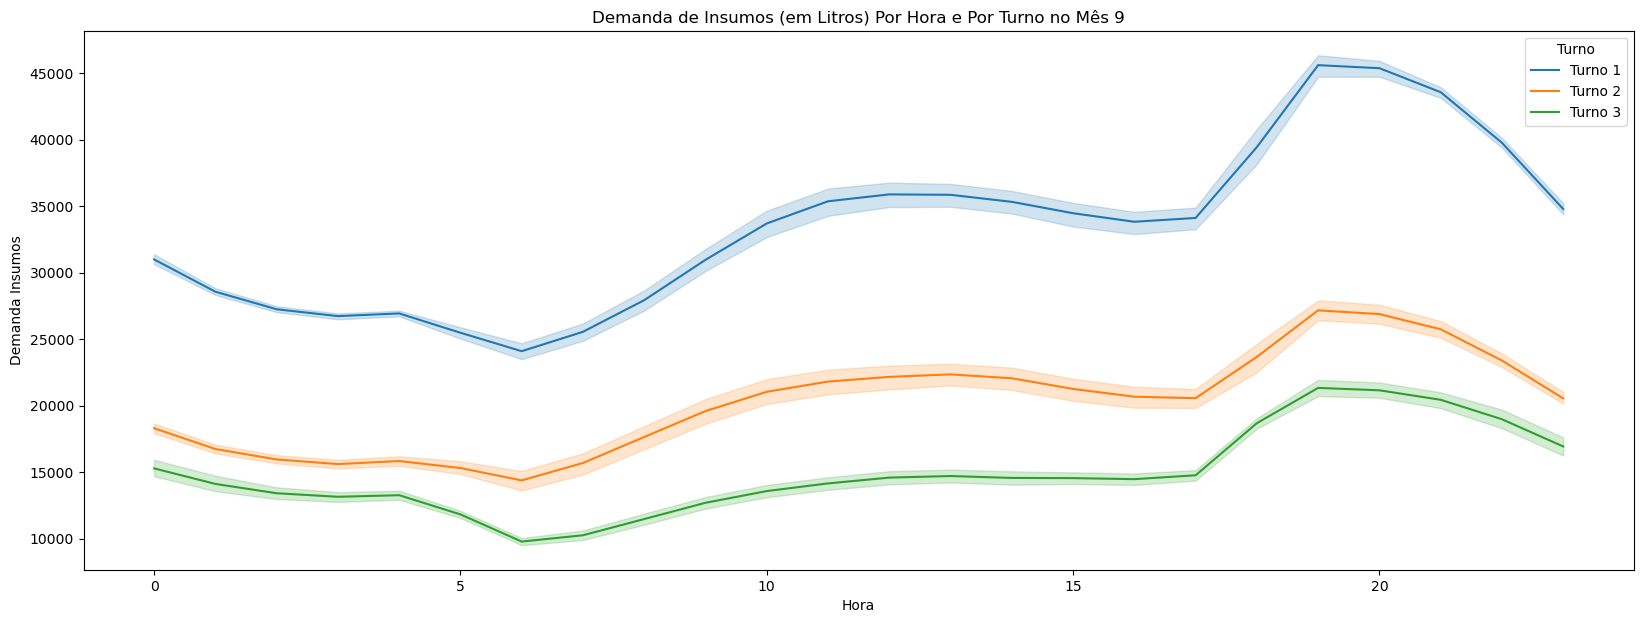

In [56]:
# Plot da variável alvo ao longo do tempo
fig, ax = plt.subplots(figsize = (20, 7))
sns.lineplot(data = df_final[df_final['Mes'] == 9], x = "Hora", y = 'Demanda_Insumos', hue = 'Turno', legend = 'full')
ax.set_xlabel("Hora")
ax.set_ylabel("Demanda Insumos")
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title(label = "Demanda de Insumos (em Litros) Por Hora e Por Turno no Mês 9")

In [57]:
# Média da demanda de insumos por turno (aqui não consideramos data, somente os dados por turno)
df_final[['Turno', 'Demanda_Insumos']].groupby('Turno').mean()

,Demanda_Insumos
Turno,
Turno 1,"32,344.97"
Turno 2,"21,042.51"
Turno 3,"17,835.41"


In [58]:
# Verifica a correlação de recursos com a variável alvo (Demanda_Insumos)
corr = df_final.corr(method = 'pearson')
power_corr = pd.DataFrame(corr['Demanda_Insumos'].sort_values(ascending = False))
print(power_corr)

                 Demanda_Insumos
Demanda_Insumos             1.00
Hora                        0.44
Indicador_MTTR              0.31
Indicador_ICE               0.14
Indicador_ITMIE             0.10
Indicador_IQMP              0.02
idx                         0.00
Mes                         0.00
Dia_Semana                 -0.04
Indicador_EME              -0.19


> Mais a frente iremos descartar a variável Indicador_IQMP devido sua baixa correlação com a variável alvo. Vamos analisar a matriz de correlação visualmente.

In [59]:
# Cria matriz de correlação
corr_idx = df_final.corr().sort_values("Demanda_Insumos", ascending = False).index
corr_sorted = df_final.loc[:, corr_idx]  

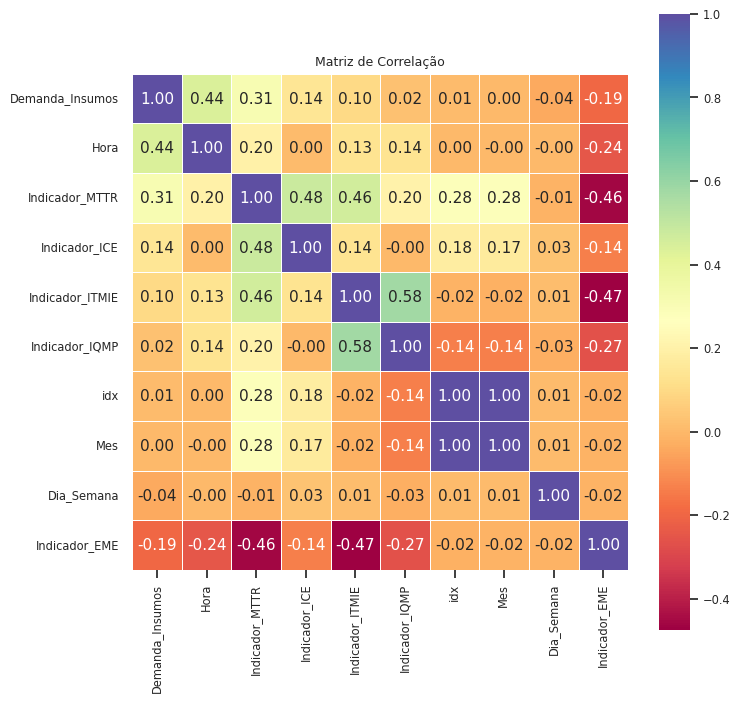

In [60]:
# Plot
plt.figure(figsize = (8,8))
sns.set(font_scale = 0.75)
ax = sns.heatmap(corr_sorted.corr().round(3), 
                 annot = True, 
                 square = True, 
                 linewidths = .70, 
                 cmap = "Spectral", 
                 fmt = ".2f", 
                 annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("Matriz de Correlação")
plt.show()

In [61]:
df_final.head()

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
0,6.20,75.07,0.08,0.06,0.10,"29,197.97",Turno 1,1,0,6,1
1,5.55,77.58,0.08,0.06,0.11,"24,657.22",Turno 1,2,1,6,1
2,5.05,78.93,0.08,0.06,0.13,"22,083.04",Turno 1,3,2,6,1
3,5.00,77.08,0.08,0.06,0.14,"20,811.14",Turno 1,4,3,6,1
4,5.10,74.05,0.08,0.06,0.12,"20,475.95",Turno 1,5,4,6,1


## Criação dos Dataloaders

In [62]:
# Usaremos um lookback de 24 horas e 7 variáveis que usaremos no treinamento do modelo
# ["idx", "Hora", "Indicador_MTTR", "Indicador_EME", "Indicador_ICE", "Indicador_ITMIE", "Demanda_Insumos"]
lookback = 24 * 7

In [63]:
# Comprimento de previsão de 24 horas
janela_previsao = 24

In [64]:
# Usamos o índice para criar o critério de divisão em treino e teste
# NÃO PODEMOS PERDER A SEQUÊNCIA TEMPORAL DOS DADOS!!!
indice_divisao = df_final["idx"].max() - janela_previsao

In [65]:
df_final["idx"].max()

8736

In [66]:
indice_divisao

8712

In [67]:
# Cria o objeto com os dados de treino (comentado linha a linha)
dados_treino = TimeSeriesDataSet(
    
    # Usa os dados até o 'indice_divisao' para treino
    df_final[lambda x: x.idx <= indice_divisao],  
    
    # Define "idx" como o índice de tempo da série
    time_idx = "idx",  
    
    # Define "Demanda_Insumos" como a variável alvo (o que queremos prever)
    target = "Demanda_Insumos",  
    
    # IDs de grupos na coluna "Turno"
    group_ids = ["Turno"],  
    
    # Define o tamanho mínimo do encoder (entrada) para a metade do 'lookback'
    min_encoder_length = lookback // 2,  
    
    # Define o tamanho máximo do encoder (entrada) igual ao 'lookback'
    max_encoder_length = lookback,  
    
    # Define o tamanho mínimo de previsão como 1
    min_prediction_length = 1,  
    
    # Define o tamanho máximo de previsão como 'janela_previsao'
    max_prediction_length = janela_previsao,  
    
    # Define "Turno" como uma variável categórica estática (não varia com o tempo)
    static_categoricals = ["Turno"],  
    
    # Define variáveis numéricas conhecidas que variam com o tempo
    time_varying_known_reals = ["idx", 
                                "Hora", 
                                "Indicador_MTTR",
                                "Indicador_EME", 
                                "Indicador_ICE",
                                "Indicador_ITMIE"],  
    
    # Define variáveis numéricas desconhecidas que variam com o tempo
    # Aqui você coloca as variáveis que deseja prever, em nosso caso a variável alvo
    time_varying_unknown_reals = ["Demanda_Insumos"], 
    
    # Normalizador para a variável alvo
    target_normalizer = GroupNormalizer(  
        
        # Agrupa pelo campo "Turno" para a normalização
        groups = ["Turno"],  
        
        # Utiliza a transformação "softplus" para a normalização
        transformation = "softplus"  
    ), 
    
     # Adiciona um índice de tempo relativo (diferença em relação ao tempo de início)
    add_relative_time_idx = True, 
    
    # Adiciona uma escala para o alvo (útil para modelos de atenção)
    add_target_scales = True,  
    
    # Adiciona o comprimento do encoder como uma característica
    add_encoder_length = True  
)

In [68]:
type(dados_treino)

pytorch_forecasting.data.timeseries.TimeSeriesDataSet

In [69]:
print(dados_treino)

TimeSeriesDataSet[length=26205](
	time_idx='idx',
	target='Demanda_Insumos',
	group_ids=['Turno'],
	weight=None,
	max_encoder_length=168,
	min_encoder_length=84,
	min_prediction_idx=1,
	min_prediction_length=1,
	max_prediction_length=24,
	static_categoricals=['Turno'],
	static_reals=['encoder_length', 'Demanda_Insumos_center', 'Demanda_Insumos_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['idx', 'Hora', 'Indicador_MTTR', 'Indicador_EME', 'Indicador_ICE', 'Indicador_ITMIE', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['Demanda_Insumos'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=['Turno'],
	center=True,
	scale_by_group=False,
	transformation='softplus',
	method_kwargs={}
),
	categorical_encoders={'__group_id__Turno': NaNLabelE

In [70]:
# Cria o objeto com os dados de validação
dados_valid = TimeSeriesDataSet.from_dataset(dados_treino, 
                                             df_final, 
                                             predict = True, 
                                             stop_randomization = True)

In [71]:
type(dados_valid)

pytorch_forecasting.data.timeseries.TimeSeriesDataSet

In [72]:
print(dados_valid)

TimeSeriesDataSet[length=3](
	time_idx='idx',
	target='Demanda_Insumos',
	group_ids=['Turno'],
	weight=None,
	max_encoder_length=168,
	min_encoder_length=84,
	min_prediction_idx=1,
	min_prediction_length=24,
	max_prediction_length=24,
	static_categoricals=['Turno'],
	static_reals=['encoder_length', 'Demanda_Insumos_center', 'Demanda_Insumos_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['idx', 'Hora', 'Indicador_MTTR', 'Indicador_EME', 'Indicador_ICE', 'Indicador_ITMIE', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['Demanda_Insumos'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=['Turno'],
	center=True,
	scale_by_group=False,
	transformation='softplus',
	method_kwargs={}
),
	categorical_encoders={'__group_id__Turno': NaNLabelEnco

In [73]:
# Cria o dataloader de treino
dl_treino = dados_treino.to_dataloader(train = True, batch_size = 32, num_workers = 2)

In [74]:
# Cria o dataloader de validação
dl_valid = dados_valid.to_dataloader(train = False, batch_size = 32, num_workers = 2)

## Criação do Modelo Temporal Fusion Transformer

In [75]:
# Callback
early_stop_callback = EarlyStopping(monitor = "val_loss", 
                                    min_delta = 1e-4, 
                                    patience = 5, 
                                    verbose = True, 
                                    mode = "min")

In [76]:
# Monitor da taxa de aprendizado
lr_logger = LearningRateMonitor()

In [77]:
# Pasta para o logger
logger = TensorBoardLogger("dados/lightning_logs")  

In [78]:
# Número de épocas de treino
epochs = 20

In [79]:
# Cria o objeto que gerencia o processo de treinamento
trainer = pl.Trainer(
    
    # Define o número máximo de épocas (ciclos completos de treinamento através do dataset)
    max_epochs = epochs,  
    
    # Define que o treinamento deve usar aceleração por GPU
    accelerator = 'gpu',  
    
    # Usa apenas uma GPU para treinamento
    devices = 1,  
    
    # Ativa a exibição do resumo do modelo
    enable_model_summary = True,  
    
     # Limita (ou "clips") o valor do gradiente para evitar "explosão dos gradientes"
    gradient_clip_val = 0.1, 
    
    # Lista de callbacks a serem usados (logger de taxa de aprendizado, critério de parada antecipada)
    callbacks = [lr_logger, early_stop_callback],  
    
    # Define o logger que irá registrar os resultados durante o treinamento
    logger = logger  
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [80]:
# Cria o modelo TFT
modelo = TemporalFusionTransformer.from_dataset(dados_treino, 
                                                learning_rate = 0.001, 
                                                hidden_size = 128, 
                                                attention_head_size = 4, 
                                                dropout = 0.1, 
                                                hidden_continuous_size = 128,
                                                output_size = 7, 
                                                loss = QuantileLoss(), 
                                                reduce_on_plateau_patience = 4)

In [81]:
# Ajusta a precisão do PyTorch
torch.set_float32_matmul_precision('high')

> Treinamento do modelo!

In [82]:
%%time
trainer.fit(modelo, train_dataloaders = dl_treino, val_dataloaders = dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 9     
3  | prescalers                         | ModuleDict                      | 2.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 201 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 541 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 473 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 66.3 K
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 538.374


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 136.789 >= min_delta = 0.0001. New best score: 401.585


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 11.658 >= min_delta = 0.0001. New best score: 389.927


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 24.525 >= min_delta = 0.0001. New best score: 365.402


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.203 >= min_delta = 0.0001. New best score: 364.199


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 364.199. Signaling Trainer to stop.


CPU times: user 13min 26s, sys: 10.9 s, total: 13min 37s
Wall time: 13min 44s


In [83]:
# Seleciona o melhor modelo
melhor_modelo = trainer.checkpoint_callback.best_model_path

In [84]:
print(melhor_modelo)

dados/lightning_logs/lightning_logs/version_1/checkpoints/epoch=12-step=10634.ckpt


In [85]:
# Carrega o melhor modelo
modelo_final = TemporalFusionTransformer.load_from_checkpoint(melhor_modelo)

## Avaliação do Modelo

In [86]:
# Valores reais em validação
valores_reais = torch.cat([y[0] for x, y in iter(dl_valid)])

In [87]:
# Previsões do modelo
valores_previstos = modelo_final.predict(dl_valid)

In [88]:
# Mean Absolute Percentage Error (MAPE)
MAPE = MeanAbsolutePercentageError()
print('Mean Absolute Percentage Error (MAPE) em Validação ')
print("MAPE: {:.2f}".format(MAPE(valores_reais, valores_previstos)))

Mean Absolute Percentage Error (MAPE) em Validação 
MAPE: 0.04


In [89]:
# Previsão nos dados de teste
# O objeto previsoes_brutas (raw) é um dicionário do qual todos os tipos de informações, incluindo quantis, 
# podem ser extraídos
previsoes_brutas, x = modelo_final.predict(dl_valid, mode = "raw", return_x = True)

In [90]:
previsoes_brutas

Output(prediction=tensor([[[25379.3301, 25594.0508, 25889.6484, 26038.0703, 26393.2754,
          26664.6719, 27202.0352],
         [22953.5195, 23310.4922, 23549.4453, 23659.8789, 24001.2852,
          24230.2734, 24703.0781],
         [21289.5879, 21678.5879, 21867.8203, 21988.6328, 22295.7246,
          22508.7891, 22935.2383],
         [20649.4980, 20971.1523, 21147.5371, 21266.1270, 21566.5742,
          21785.6992, 22198.2012],
         [20503.4570, 20755.7266, 20934.9082, 21049.5938, 21360.2383,
          21582.3711, 21989.3477],
         [21023.4219, 21271.8359, 21444.8711, 21587.8477, 21880.4023,
          22127.0684, 22496.5176],
         [22253.1406, 22615.5742, 22805.4141, 22993.6602, 23327.4180,
          23544.5938, 23932.6758],
         [21302.0723, 21741.1680, 22017.6719, 22242.5508, 22544.5137,
          22888.2617, 23345.2520],
         [23200.7578, 23564.5938, 23792.4883, 24000.6094, 24319.1367,
          24578.4922, 24976.2344],
         [26309.7969, 26771.5508, 269

In [91]:
print('Shape das Previsões:', previsoes_brutas['prediction'].shape)

Shape das Previsões: torch.Size([3, 24, 7])


Previsão da Demanda de Insumos com Base em Indicadores de Produção (Por Turno)


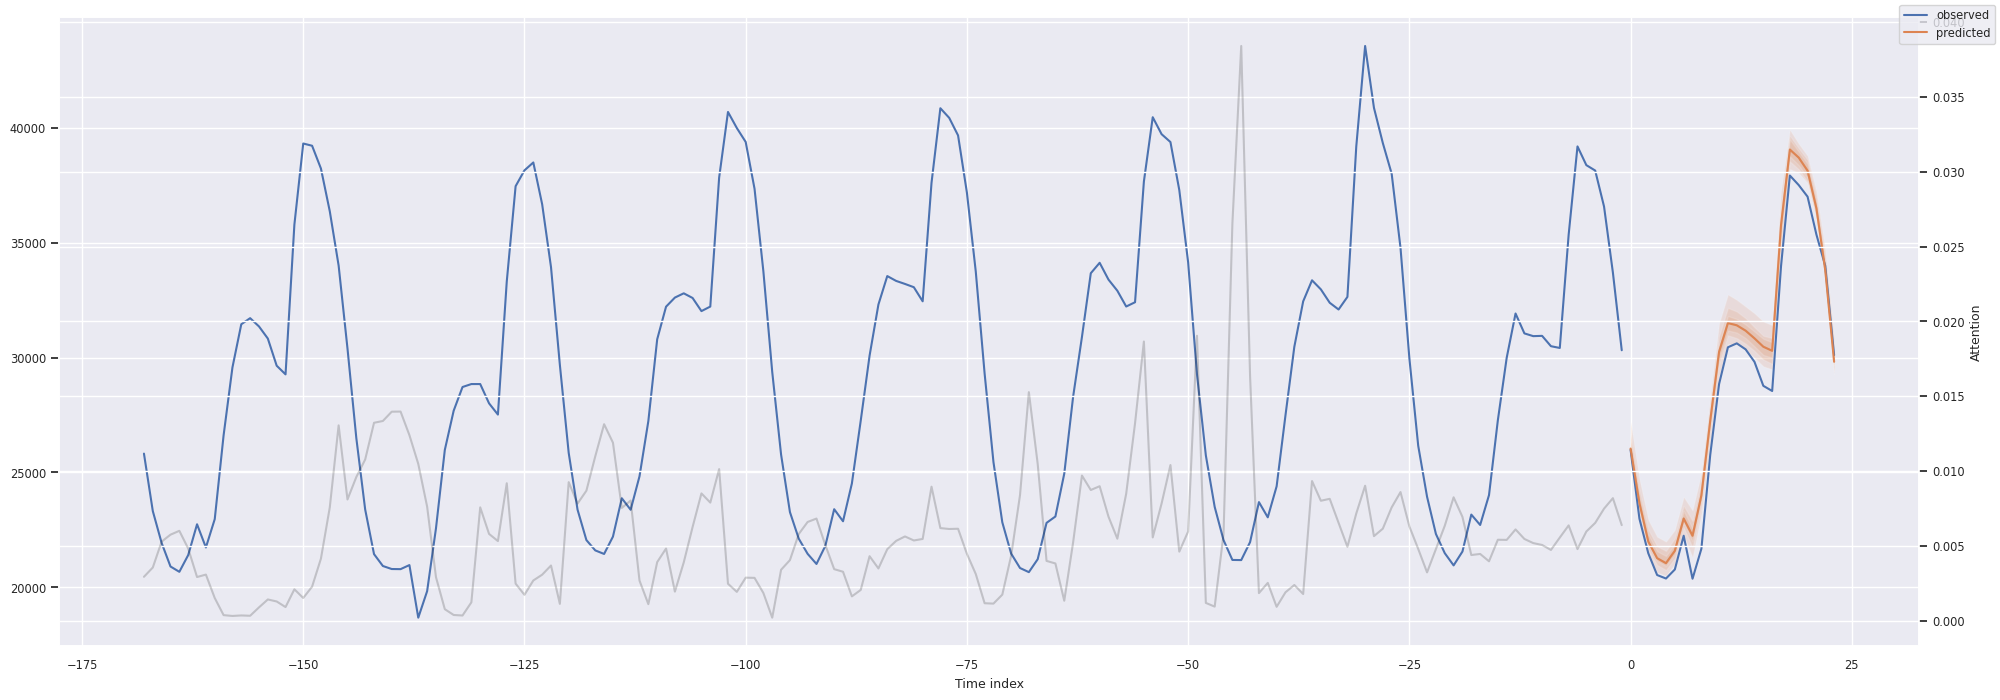

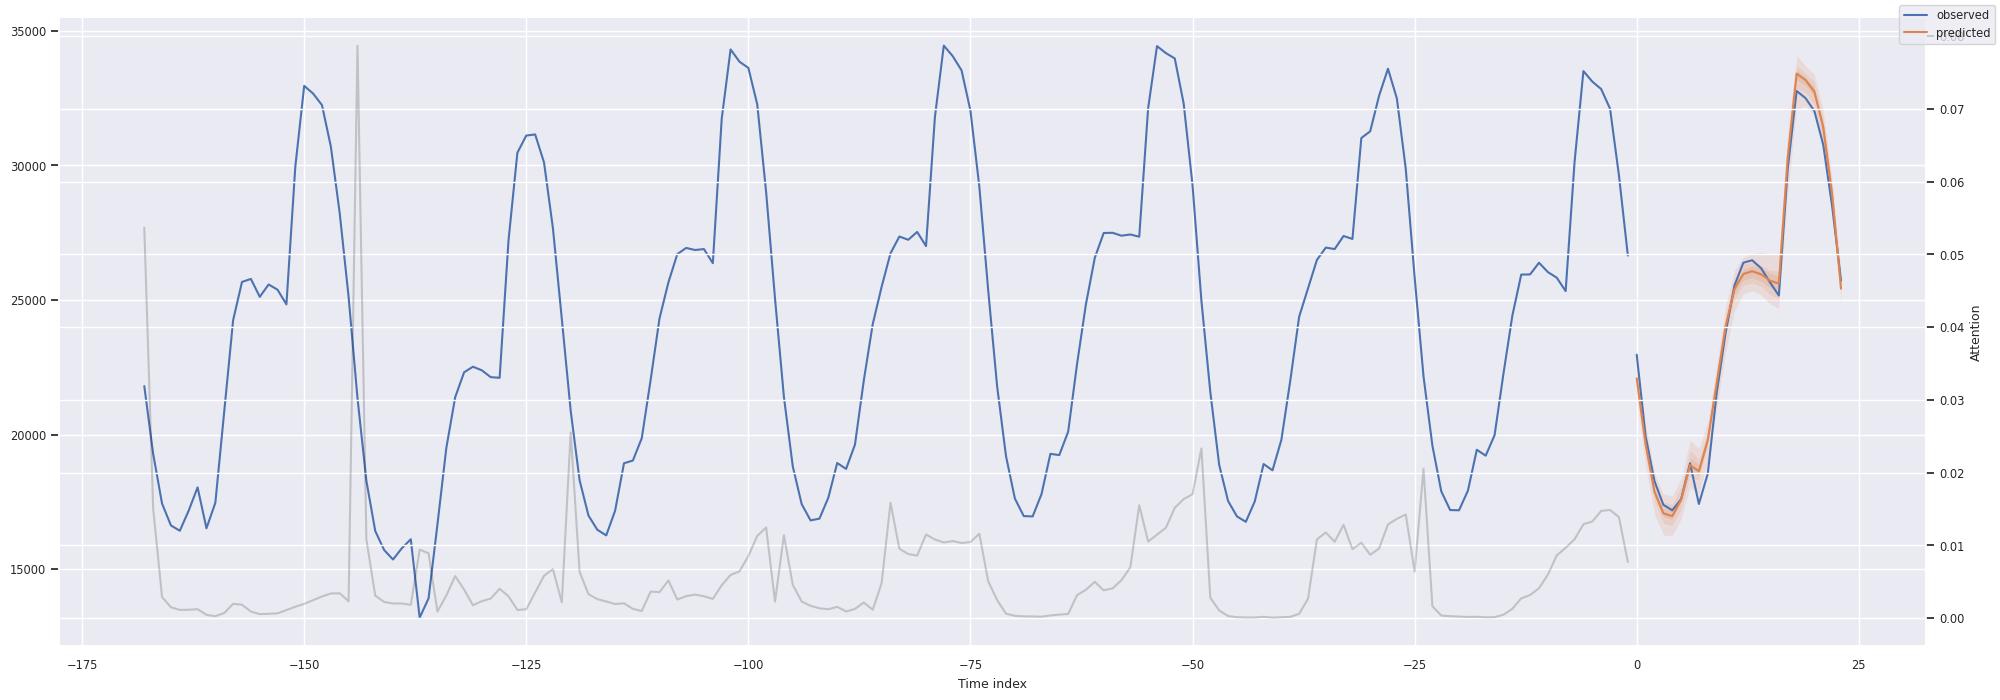

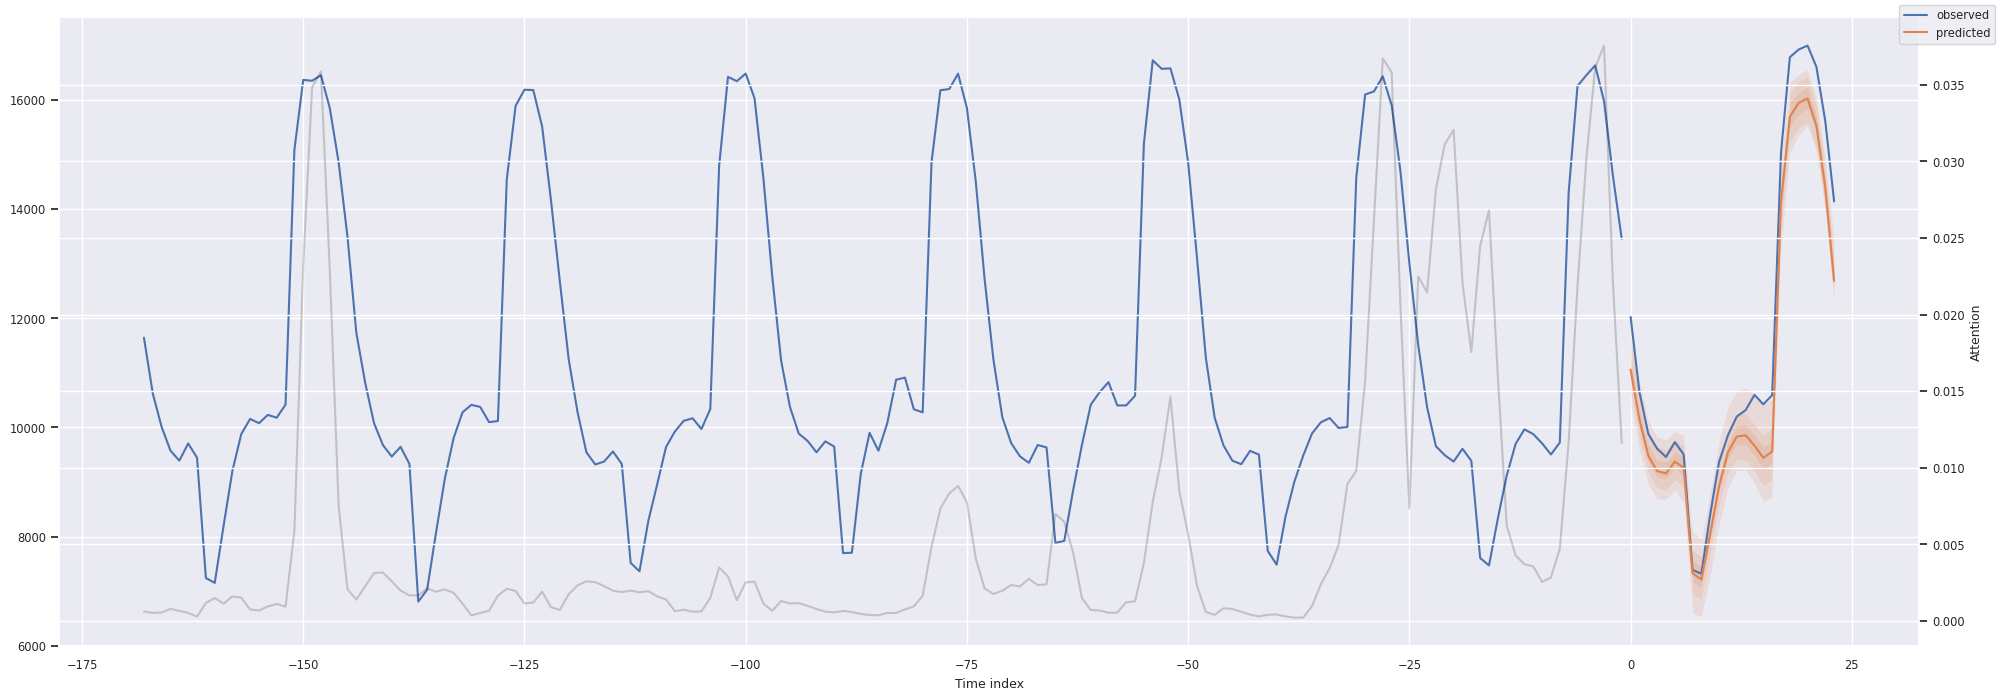

In [92]:
# Previsão por turno
print("Previsão da Demanda de Insumos com Base em Indicadores de Produção (Por Turno)")
for i in range(3):    
    fig, ax = plt.subplots(figsize = (20, 7))    
    modelo_final.plot_prediction(x, previsoes_brutas, idx = i, ax = ax)

In [93]:
# Previsões em modo "quantiles"
predictions, x = modelo_final.predict(dl_valid, mode = "quantiles", return_x = True)

In [94]:
# Print das previsões de quantil no conjunto de dados de validação
print(predictions.shape)
print('Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]')

torch.Size([3, 24, 7])
Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


In [95]:
torch.set_printoptions(precision = 2)
print('Previsões em Validação Para o Turno 1')
predictions[0]

Previsões em Validação Para o Turno 1


tensor([[25379.33, 25594.05, 25889.65, 26038.07, 26393.28, 26664.67, 27202.04],
        [22953.52, 23310.49, 23549.45, 23659.88, 24001.29, 24230.27, 24703.08],
        [21289.59, 21678.59, 21867.82, 21988.63, 22295.72, 22508.79, 22935.24],
        [20649.50, 20971.15, 21147.54, 21266.13, 21566.57, 21785.70, 22198.20],
        [20503.46, 20755.73, 20934.91, 21049.59, 21360.24, 21582.37, 21989.35],
        [21023.42, 21271.84, 21444.87, 21587.85, 21880.40, 22127.07, 22496.52],
        [22253.14, 22615.57, 22805.41, 22993.66, 23327.42, 23544.59, 23932.68],
        [21302.07, 21741.17, 22017.67, 22242.55, 22544.51, 22888.26, 23345.25],
        [23200.76, 23564.59, 23792.49, 24000.61, 24319.14, 24578.49, 24976.23],
        [26309.80, 26771.55, 26993.74, 27254.14, 27545.67, 27820.83, 28251.01],
        [29183.13, 29730.04, 29946.86, 30253.38, 30558.86, 30921.66, 31492.27],
        [30588.45, 30974.57, 31184.49, 31504.41, 31811.98, 32164.84, 32747.13],
        [30567.08, 30850.56, 31092.91, 3

In [96]:
# Valores reais do Turno 1 para as últimas 24 horas
dados_reais = df_final[df_final['Turno'] == 'Turno 1']
dados_reais[-24:]

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
8712,12.90,53.44,0.08,0.05,0.11,"25,985.30",Turno 1,8713,0,5,12
8713,12.51,52.47,0.08,0.06,0.10,"22,984.03",Turno 1,8714,1,5,12
8714,11.96,53.18,0.08,0.06,0.10,"21,479.34",Turno 1,8715,2,5,12
8715,11.55,52.89,0.08,0.07,0.10,"20,532.32",Turno 1,8716,3,5,12
8716,11.33,51.44,0.08,0.07,0.13,"20,380.23",Turno 1,8717,4,5,12
8717,11.31,48.95,0.08,0.07,0.09,"20,773.64",Turno 1,8718,5,5,12
8718,11.33,48.96,0.08,0.06,0.11,"22,243.85",Turno 1,8719,6,5,12
8719,11.11,49.00,0.08,0.06,0.11,"20,372.12",Turno 1,8720,7,5,12
8720,10.83,48.63,0.08,13.05,6.67,"21,676.05",Turno 1,8721,8,5,12
8721,11.34,47.81,0.08,140.82,27.14,"25,764.26",Turno 1,8722,9,5,12


## Interpretabilidade em Nível de Recurso

In [97]:
# Previsões brutas
previsoes_brutas, x = modelo_final.predict(dl_valid, mode = "raw", return_x = True)

In [98]:
# Interpretação
interpretation = modelo_final.interpret_output(previsoes_brutas, reduction = "sum")

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x400 with 1 Axes>,
 'decoder_variables': <Figure size 700x375 with 1 Axes>}

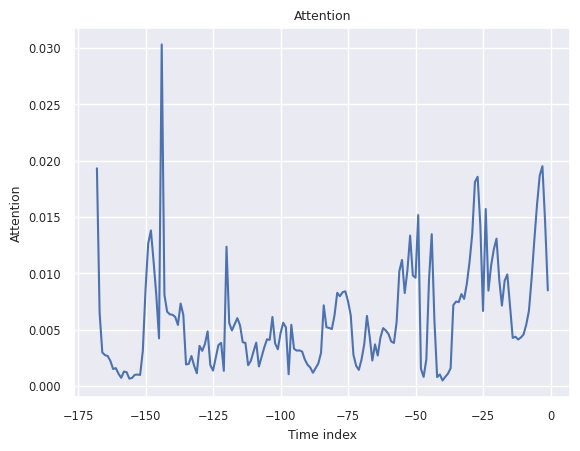

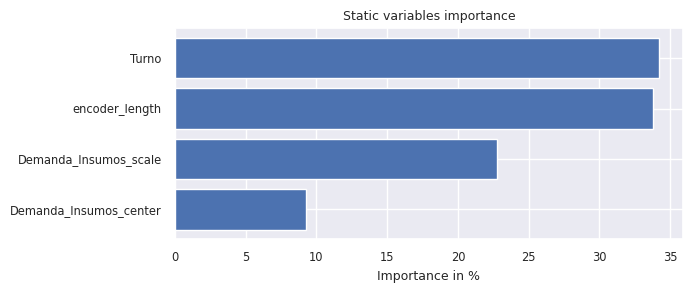

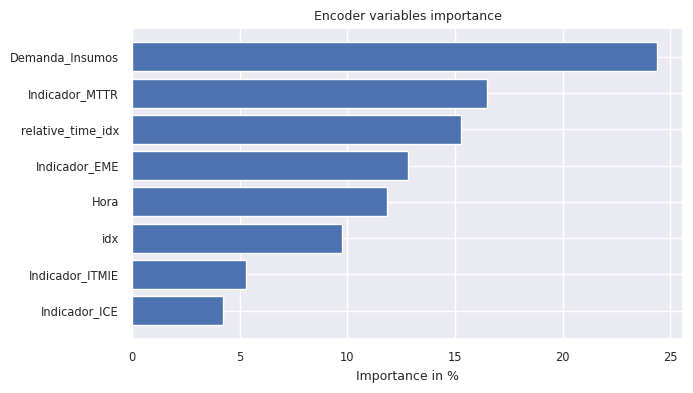

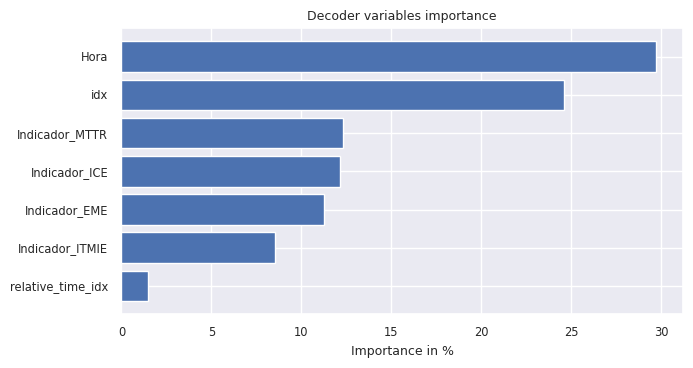

In [99]:
# Plot
modelo_final.plot_interpretation(interpretation)

Não é de surpreender que demanda de insumos observada no passado seja a principal variável no codificador e as variáveis relacionadas aos indicadores estejam entre os principais preditores no decodificador.

Os padrões gerais de atenção parecem ser que as observações mais recentes são mais importantes que as mais antigas. Isso confirma a intuição. A atenção média muitas vezes não é muito útil - observar a atenção pelo exemplo mais recente é mais perspicaz porque os padrões não são calculados em média.

## Forecast (Previsão) da Demanda de Insumos Por Turno 

Começaremos preparando os dados para o enceder e para o decoder, componentes do modelo.

Para criar nossos dados do codificador, precisamos simplesmente de uma janela de lookback dos últimos dados disponíveis. O decodificador receberá o range de tempo (horas em nosso caso) que desejamos fazer as previsões.

In [100]:
# Define os dados do encoder
encoder_data = df_final[lambda x: x.idx > x.idx.max() - lookback]
encoder_data

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
8568,9.90,88.85,0.08,0.06,0.13,"26,492.27",Turno 1,8569,0,6,12
8569,9.68,89.18,0.08,0.04,0.16,"23,386.57",Turno 1,8570,1,6,12
8570,8.70,89.13,0.08,0.05,0.14,"21,442.84",Turno 1,8571,2,6,12
8571,8.30,89.68,0.08,0.06,0.14,"20,925.73",Turno 1,8572,3,6,12
8572,8.18,90.33,0.08,0.05,0.14,"20,793.92",Turno 1,8573,4,6,12
...,...,...,...,...,...,...,...,...,...,...,...
26203,9.45,62.41,0.07,0.05,0.10,"16,926.77",Turno 3,8732,19,5,12
26204,9.04,63.99,0.08,0.05,0.10,"16,998.80",Turno 3,8733,20,5,12
26205,8.01,69.67,0.08,0.07,0.10,"16,608.88",Turno 3,8734,21,5,12
26206,7.60,70.31,0.08,0.06,0.11,"15,614.89",Turno 3,8735,22,5,12


Para os dados do decodificador, precisamos fornecer dados de covariáveis futuras para a duração do período de previsão desejado. Os dados do decodificador devem ter o comprimento da nossa previsão (24 horas) vezes o número de turnos (3) então um comprimento de 72.

O processo consiste em repetir o último conjunto de medições horárias 24 vezes e depois corrigir/limpar os dados da covariável.

In [101]:
# Últimos pontos de dados 
last_data = df_final[lambda x: x.idx == x.idx.max()]

In [102]:
last_data

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
8735,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8736,23,5,12
17471,6.88,72.90,0.08,0.06,0.09,"25,713.41",Turno 2,8736,23,5,12
26207,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8736,23,5,12


In [103]:
# Cria modelo de dataframe do decodificador
decoder_data = last_data.loc[last_data.index.repeat(24)].reset_index(drop = True)

In [104]:
decoder_data.shape

(72, 11)

In [105]:
decoder_data

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
0,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8736,23,5,12
1,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8736,23,5,12
2,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8736,23,5,12
3,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8736,23,5,12
4,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8736,23,5,12
...,...,...,...,...,...,...,...,...,...,...,...
67,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8736,23,5,12
68,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8736,23,5,12
69,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8736,23,5,12
70,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8736,23,5,12


In [106]:
# Corrigir nossa coluna de índice de tempo para cada grupo de turnos
start = 8736
temp2, temp = [], []
for j in range(3):  
    for i in range(1,25,1):
        x = start + i
        temp.append(x)

In [107]:
temp2.append(temp)
new_range = list(np.concatenate(temp2))

In [108]:
decoder_data['idx'] = new_range
decoder_data

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
0,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8737,23,5,12
1,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8738,23,5,12
2,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8739,23,5,12
3,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8740,23,5,12
4,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8741,23,5,12
...,...,...,...,...,...,...,...,...,...,...,...
67,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8756,23,5,12
68,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8757,23,5,12
69,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8758,23,5,12
70,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8759,23,5,12


In [109]:
# Corrigir nossa coluna de contagem por hora
temp4, temp3 = [], []
for j in range(3):  
    for i in range(24):
        temp3.append(i)

In [110]:
temp4.append(temp3)
new_hours = list(np.concatenate(temp4))

In [111]:
decoder_data['Hora'] = new_hours
decoder_data

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
0,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8737,0,5,12
1,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8738,1,5,12
2,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8739,2,5,12
3,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8740,3,5,12
4,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8741,4,5,12
...,...,...,...,...,...,...,...,...,...,...,...
67,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8756,19,5,12
68,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8757,20,5,12
69,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8758,21,5,12
70,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8759,22,5,12


In [112]:
# Corrigir nossa coluna de dias da semana
decoder_data["Dia_Semana"] = 6
decoder_data

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
0,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8737,0,6,12
1,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8738,1,6,12
2,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8739,2,6,12
3,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8740,3,6,12
4,6.88,72.90,0.08,0.06,0.09,"30,107.98",Turno 1,8741,4,6,12
...,...,...,...,...,...,...,...,...,...,...,...
67,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8756,19,6,12
68,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8757,20,6,12
69,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8758,21,6,12
70,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8759,22,6,12


## Deploy e Uso do Modelo Para Diferentes Horizontes de Previsões 

In [113]:
# Agora criamos nosso dataframe de conjunto de dados de previsão combinado
new_pred_data = pd.concat([encoder_data, decoder_data], ignore_index = True)
new_pred_data

,Indicador_MTTR,Indicador_EME,Indicador_ICE,Indicador_ITMIE,Indicador_IQMP,Demanda_Insumos,Turno,idx,Hora,Dia_Semana,Mes
0,9.90,88.85,0.08,0.06,0.13,"26,492.27",Turno 1,8569,0,6,12
1,9.68,89.18,0.08,0.04,0.16,"23,386.57",Turno 1,8570,1,6,12
2,8.70,89.13,0.08,0.05,0.14,"21,442.84",Turno 1,8571,2,6,12
3,8.30,89.68,0.08,0.06,0.14,"20,925.73",Turno 1,8572,3,6,12
4,8.18,90.33,0.08,0.05,0.14,"20,793.92",Turno 1,8573,4,6,12
...,...,...,...,...,...,...,...,...,...,...,...
571,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8756,19,6,12
572,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8757,20,6,12
573,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8758,21,6,12
574,6.88,72.90,0.08,0.06,0.09,"14,143.58",Turno 3,8759,22,6,12


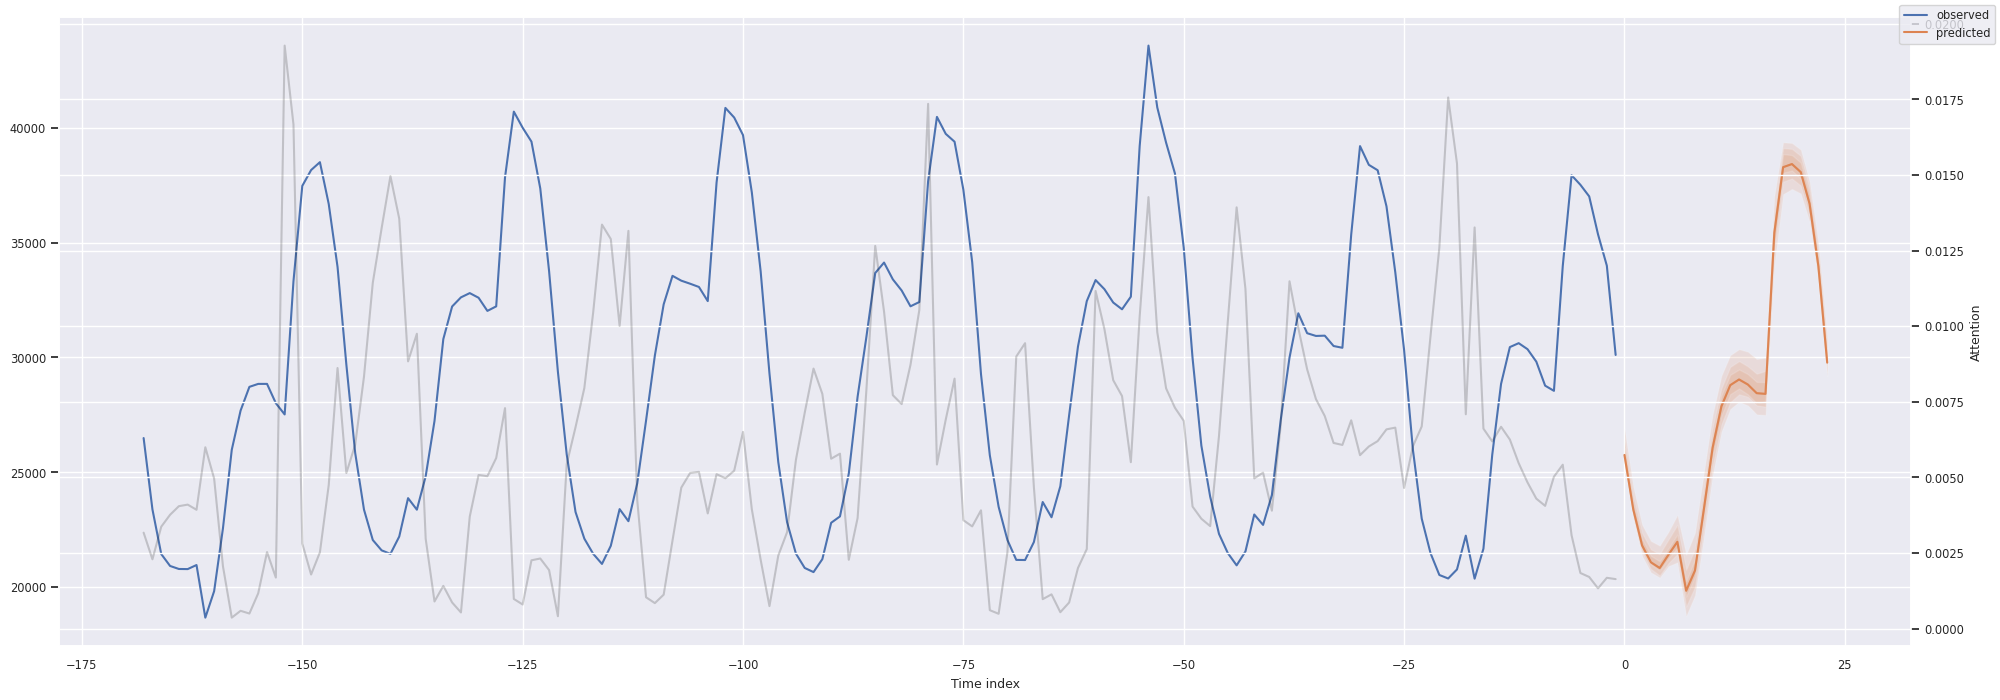

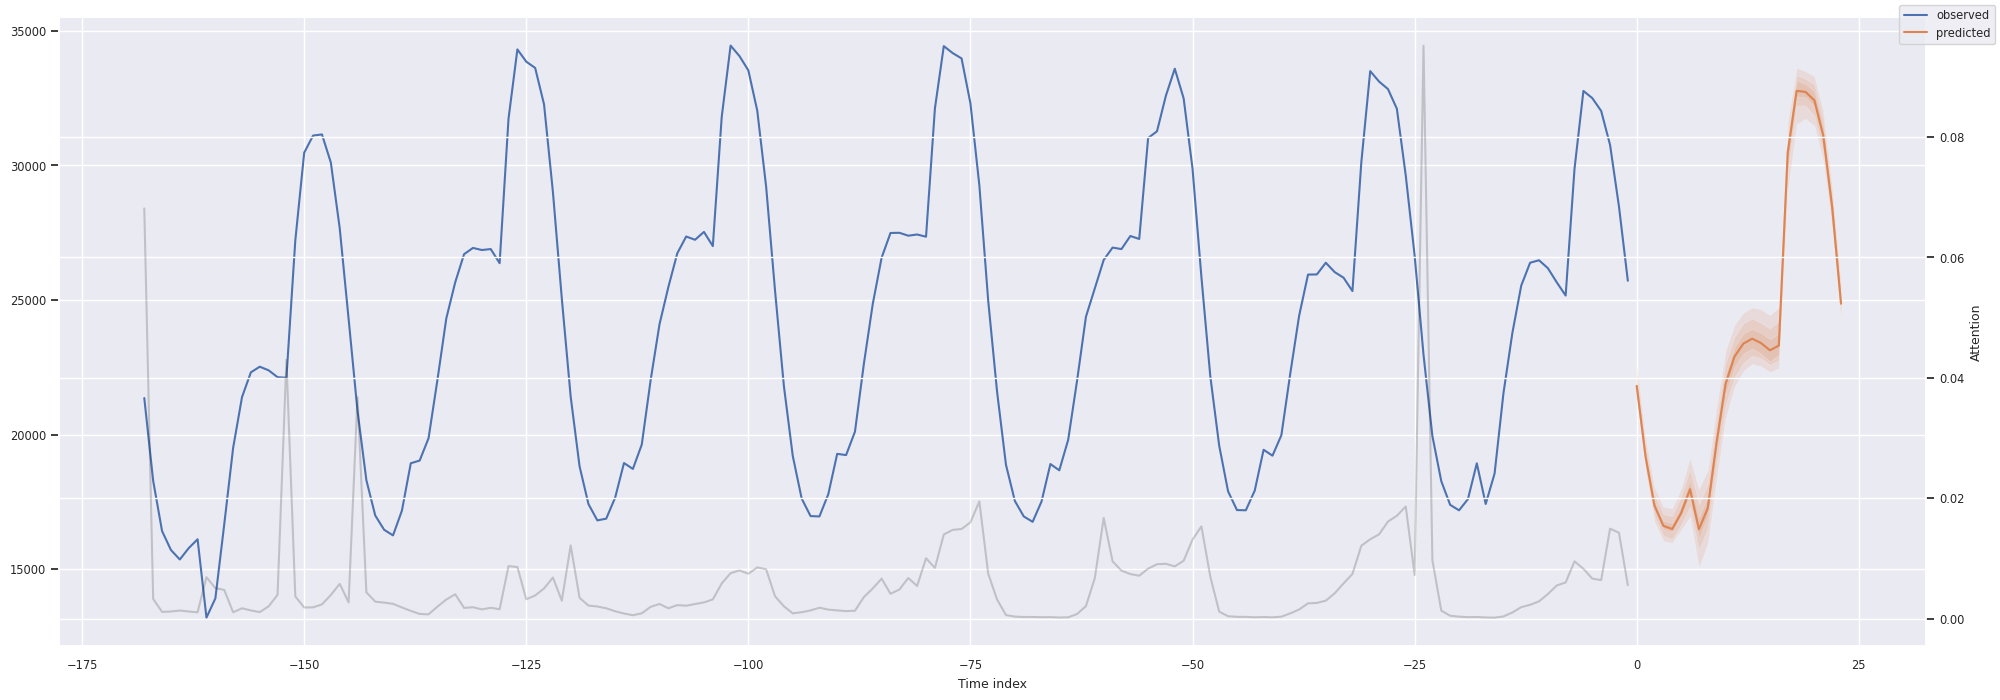

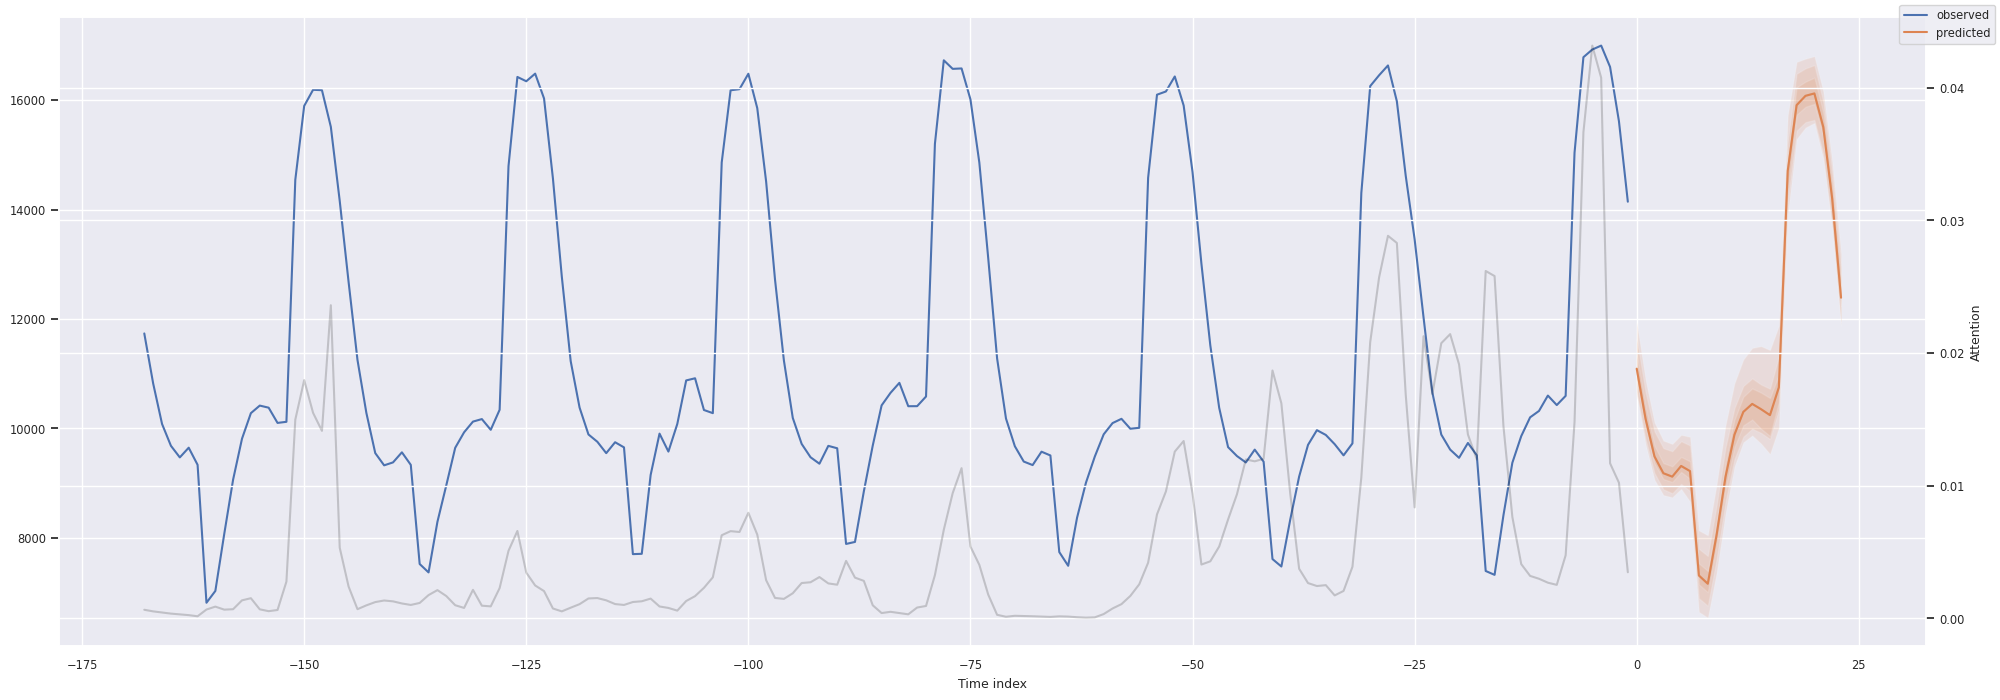

In [114]:
# Plot das previsões de amostra
inf_raw_predictions, inf_x = modelo_final.predict(new_pred_data, mode = "raw", return_x = True)

for i in range(3):    
    fig, ax = plt.subplots(figsize = (20, 7))
    modelo_final.plot_prediction(inf_x, inf_raw_predictions, show_future_observed = False, idx = i, ax = ax)